## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from random import shuffle

%matplotlib inline

from vehicle_detection_helper import *

In [2]:
# load images
images = glob.glob('./test_images/*.jpg')

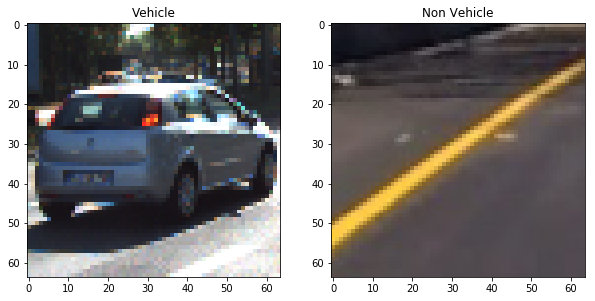

In [3]:
img_vehicle = cv2.imread('./examples/58.png')
img_non_vehicle = cv2.imread('./examples/extra27.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.set_title("Vehicle")
ax1.imshow(cv2.cvtColor(img_vehicle, cv2.COLOR_BGR2RGB))

ax2.set_title("Non Vehicle")
ax2.imshow(cv2.cvtColor(img_non_vehicle, cv2.COLOR_BGR2RGB))

/Users/matheus.souza/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


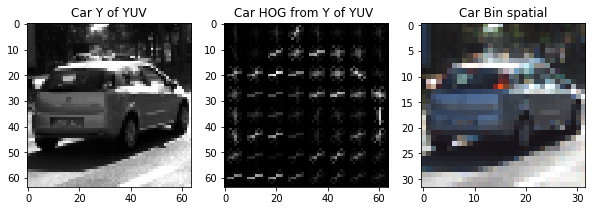

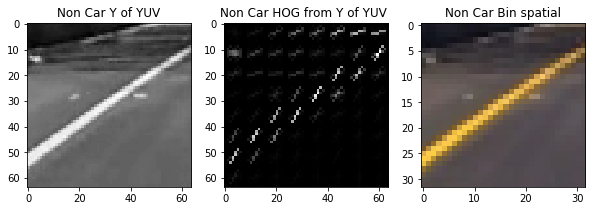

In [4]:
# HOG

pix_per_cell = 8
cell_per_block = 2
orient = 9

y_channel = convert_color(img_vehicle, 'YUV')[:,:, 0]
_, hog_yuv = get_hog_features(y_channel, 
                        orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

img_car_bs = bin_spatial(convert_color(img_vehicle), size=(32, 32))

y_channel_nc = convert_color(img_non_vehicle, 'YUV')[:,:, 0]
_, hog_yuv_nc = get_hog_features(y_channel_nc, 
                        orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

img_car_bs_nc = bin_spatial(convert_color(img_non_vehicle), size=(32, 32))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.set_title("Car Y of YUV")
ax1.imshow(y_channel, cmap='gray')

ax2.set_title("Car HOG from Y of YUV ")
ax2.imshow(hog_yuv, cmap='gray')

ax3.set_title("Car Bin spatial")
ax3.imshow(cv2.cvtColor(img_car_bs, cv2.COLOR_BGR2RGB), cmap='gray')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.set_title("Non Car Y of YUV")
ax1.imshow(y_channel_nc, cmap='gray')

ax2.set_title("Non Car HOG from Y of YUV ")
ax2.imshow(hog_yuv_nc, cmap='gray')

ax3.set_title("Non Car Bin spatial")
ax3.imshow(cv2.cvtColor(img_car_bs_nc, cv2.COLOR_BGR2RGB), cmap='gray')


# Track vehicle pipeline

Load dataset 

1) histogram of color
   use HLS, LUV or other, to split the pixels of car from non cars
   
2) spatial binning of color
   downs the resolution mantaning the resources
3) compute HOG (Histogram of oriented gradients)
   allows for robust variation in the shape
4) combine and normalize features
5) build the SVM classifier
6) build windows

As imagens de veículos para teste foram separadas manualmente, por conter imagens em series (muito parecidas). Isso poderia fazer com que o teste e treino tivessem imagens muito semelhantes, causando overfitting. 

In [28]:
# load the dataset

from sklearn.model_selection import train_test_split

def load_data(path, is_car=True):
    X = []
    y = None
    
    files = glob.glob(path)
    
    for file in files:
        img = cv2.imread(file)
        X.append(img)
        
    if is_car:
        y = np.ones(len(X))
    else:
        y = np.zeros(len(X))

    return np.array(X), y

X_train, y_train = load_data('./data/vehicles/train_data/**/*.png')
X_test, y_test = load_data('./data/vehicles/test_data/**/*.png')

rand_state = np.random.randint(0, 100)
X_data_noncar, y_data_noncar = load_data('./data/non-vehicles/**/*.png', False)

X_train_noncar, X_test_noncar, y_train_noncar, y_test_noncar = train_test_split(
    X_data_noncar, y_data_noncar, test_size=0.2, random_state=rand_state)

n_train_car = len(X_train)
n_test_car = len(X_test)
n_train_noncar = len(X_train_noncar)
n_test_noncar = len(X_test_noncar)

# metrics

image_shape = X_train[0].shape[:-1]

print("Number of training car examples =", n_train_car)
print("Number of testing car examples =", n_test_car)

print("Number of training non car examples =", n_train_noncar)
print("Number of testing non car examples =", n_test_noncar)

print("Image data shape =", image_shape)

Number of training car examples = 7033
Number of testing car examples = 1759
Number of training non car examples = 7174
Number of testing non car examples = 1794
Image data shape = (64, 64)


## Train the model

In [29]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

def extract_features(images, orient, pix_per_cell, cell_per_block, 
                     cspace='LUV', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256)):
    features = []
    for image in images:
        image_featues = []
        
        feature_image = convert_color(image, cspace)  
        spatial_features = bin_spatial(feature_image, size=spatial_size, feature_vector=True)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
            
        hog_features = np.ravel(hog_features)
        '''
        print('colorspace', cspace)
        print('feature_image shape', feature_image.shape)
        print('spatial_features shape', spatial_features.shape)
        print('hist_features shape', hist_features.shape)
        print('hog_features shape', np.array(hog_features).shape)
        '''
        image_featues.append(spatial_features)
        image_featues.append(hist_features)
        image_featues.append(hog_features)
        
        features.append(np.concatenate(image_featues))
        
    return features

In [30]:
spatial = (32, 32)
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace='YCrCb'

X_train_features = extract_features(X_train, orient, pix_per_cell, cell_per_block, 
                                    spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_train_features_noncar = extract_features(X_train_noncar, orient, pix_per_cell, cell_per_block,  
                                           spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_test_features = extract_features(X_test, orient, pix_per_cell, cell_per_block,  
                                   spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_test_features_noncar = extract_features(X_test_noncar, orient, pix_per_cell, cell_per_block,  
                                          spatial_size=spatial, hist_bins=histbin, cspace=cspace)

In [31]:
print(np.array(X_train_features).shape)

(7033, 8460)


In [32]:
from sklearn.utils import shuffle
import pickle

X = np.vstack((X_train_features, X_train_features_noncar)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((y_train, y_train_noncar))

scaled_X, y = shuffle(scaled_X, y)

X_t = np.vstack((X_test_features, X_test_features_noncar)).astype(np.float64)                        
X_scaler_test = StandardScaler().fit(X_t)
scaled_X_test = X_scaler_test.transform(X_t)

# Define the labels vector
y_t = np.hstack((y_test, y_test_noncar))

svc = LinearSVC()
t=time.time()
svc.fit(scaled_X, y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_t), 4))

pickle.dump((svc, X_scaler), open('svc_classifier.p', 'wb'))

29.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9851


In [33]:
t=time.time()
n_predict = 20
pred = svc.predict(scaled_X_test[0:n_predict])
print('My SVC predicts: ', pred)
print('For these',n_predict, 'labels: ', y_t[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

corrects = [1 for i, j in zip(pred, y_t[0:n_predict]) if i == j]
print((len(corrects) / n_predict), "accuracy in predictions")

My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  0.  0.]
For these 20 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
0.00618 Seconds to predict 20 labels with SVC
0.8 accuracy in predictions


In [2]:
# checkpoint for the classifier
import pickle
import time

svc, X_scaler = pickle.load(open('svc_classifier.p', mode='rb'))

shape (720, 1280, 3)
qtd small 160
qtd medium 60
qtd large 18


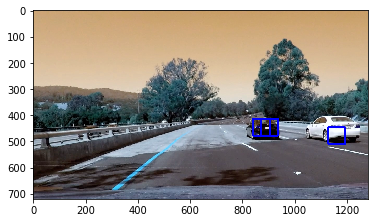

In [34]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features([test_img], orient, pix_per_cell, cell_per_block, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins)
        #5) Scale extracted features to be fed to classifier
        #features = np.array(features[0])
        #print(features.shape)
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

image = cv2.imread('./test_images/test4.jpg')
print('shape', image.shape)
draw_image = np.copy(image)

windows_small = slide_window(image, x_start_stop=[200, None], y_start_stop=[350, 564], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
print('qtd small', len(windows_small))

windows_medium = slide_window(image, x_start_stop=[150, None], y_start_stop=[350, 700], 
                    xy_window=(100, 100), xy_overlap=(0.3, 0.3))
print('qtd medium', len(windows_medium))

windows_large = slide_window(image, x_start_stop=[100, None], y_start_stop=[350, None], 
                    xy_window=(300, 200), xy_overlap=(0.5, 0.6))
print('qtd large', len(windows_large))

windows = []

for bbox in  windows_small:
    windows.append(bbox)

'''
for bbox in  windows_medium:
    windows.append(bbox)

for bbox in  windows_large:
    windows.append(bbox)
'''
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
#draw_image = draw_boxes(draw_image, windows2, color=(0, 255, 0), thick=6)

plt.imshow(draw_image)

/Users/matheus.souza/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(0,)


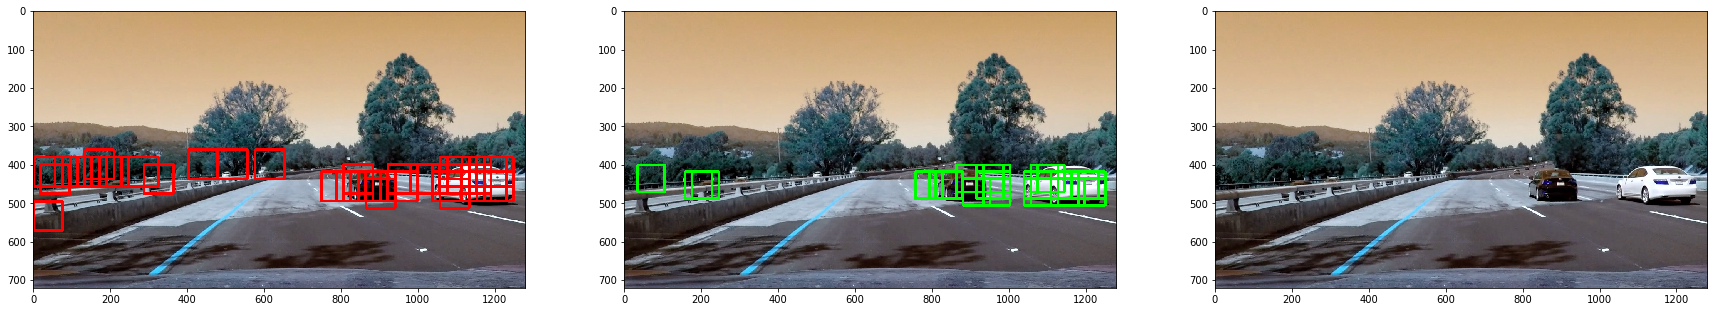

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, window_color, debug=None):
    
    draw_img = None
    if debug is not None:
        draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    '''
    print('nxblocks', nxblocks)
    print('nyblocks', nyblocks)
    print('nfeat_per_block', nfeat_per_block)
    print('nblocks_per_window', nblocks_per_window)
    print('nxsteps', nxsteps)
    print('nysteps', nysteps)
    '''
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size, feature_vector=True)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            test_features = X_scaler.transform(all_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            if debug == 1: # show all windows
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),window_color,6) 
            elif debug == 2 and test_prediction == 1: #draws the predictions
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),window_color,6) 
            else: # just adds the window on bbox_list to return
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)

                    points = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                    bbox_list.append(points)

                

    return draw_img, bbox_list

image = cv2.imread('./test_images/test4.jpg')
draw_image = np.copy(image)

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
debug = 2

ystart = 360
ystop = 630

scale = 1.2
out1, bbox1 = find_cars(draw_image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (255,0,0), debug=debug)


ystart = 400
ystop = 550

scale = 1.1
out2, bbox2 = find_cars(draw_image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), debug=debug)

ystart = 500
ystop = 700

scale = 2.0
out3, bbox3 = find_cars(draw_image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,0,255), debug=debug)

#print(bbox1, bbox2, bbox3)
bbox_list = []

'''
for bbox in bbox1:
    bbox_list.append(bbox)
'''

for bbox in bbox2:
    bbox_list.append(bbox)
    
for bbox in bbox3:
    bbox_list.append(bbox)

print(np.array(bbox_list).shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.imshow(out1)
ax2.imshow(out2)
ax3.imshow(out3)

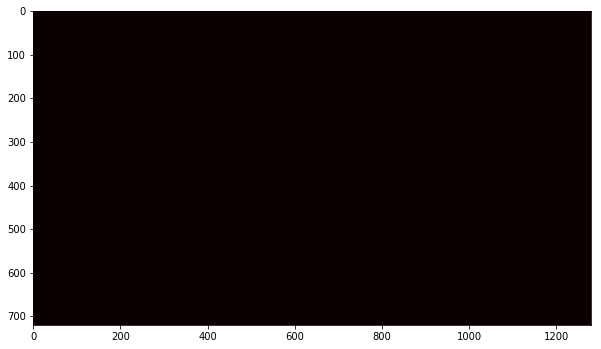

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
heat_map = add_heat(heat, bbox_list)
heat_map = apply_threshold(heat_map, 3)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(heat_map, cmap='hot')

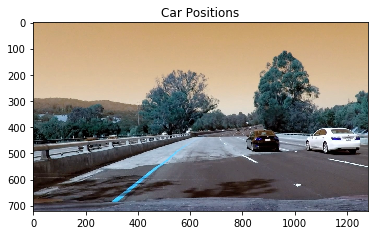

In [5]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap = np.clip(heat_map, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')

## Testing on video

In [6]:
from laneline_detection import *

In [342]:
class VehicleTracking():
    def __init__(self):
        
        # number of frames heats are in buffer
        self.n_frame_buffer = 0
        self.n_frame_nosearch = 0
        
        self.n_frame_to_flush = 10#correct 15 # aprox x sec
        self.n_frame_to_fullsearch = 5
        self.window_searcharea = None
        
        self.fullsearch = True
        
        self.heat_img = None
        
        self.min_heatmap_threshold = 0
        
        self.last_heatmap = None
        
        self.old_frame = None
    
    def add_heat(self, bbox_list, shape_img):
        
        if self.heat_img is None:
            self.heat_img = np.zeros_like(shape_img).astype(np.float)
            
        if self.last_heatmap is None:
            self.last_heatmap = np.zeros_like(shape_img).astype(np.float)
        
        h_nonzero = np.nonzero(self.heat_img)
        
        # flush the buffer and change the area of detection
        if self.n_frame_buffer > self.n_frame_to_flush and len(h_nonzero[0]) > 0:
            
            n_max = np.max(self.heat_img[h_nonzero])
            
            #heatmap_threshold = 60
            #0.8 was good
            heatmap_threshold = max(40, n_max * .7)
            
            print('flushing', np.min(self.heat_img[h_nonzero]), n_max, heatmap_threshold)
            
            self.apply_threshold(heatmap_threshold)
            self.n_frame_buffer = 0
            self.heat_img = np.zeros_like(shape_img).astype(np.float)
            
            self.fullsearch = False
        
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heat_img[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
        
        self.n_frame_buffer += 1
        
        return self.last_heatmap
        
    def apply_threshold(self, heatmap_threshold):
        # Zero out pixels below the threshold
        self.heat_img[self.heat_img <= heatmap_threshold] = 0
        self.last_heatmap = np.copy(self.heat_img)
    

In [471]:
def detect_lines(image, left_line, right_line, bbox_car_list):
    
    # allow rollback in case of bad detection
    left_previous_state = copy.deepcopy(left_line)
    right_previous_state = copy.deepcopy(right_line)
    
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    grad_x = abs_sobel_thresh(image, thresh=(20, 130), sobel_kernel=5)
    #grad_x = abs_sobel_thresh(img_sobel, thresh=(20, 130), sobel_kernel=9)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]

    thresh = (100, 200)
    h_binary = np.zeros_like(H)
    h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1


    #project
    #s_tresh = hls_threshold(image, thresh=(130, 255))
    s_tresh = hls_threshold(image, thresh=(90, 255))

    combined = np.zeros_like(s_tresh)
    combined[((s_tresh == 1) & (s_tresh != h_binary)) | ((grad_x == 1) ) ] = 1

    imshape = image.shape

    rows = imshape[0]
    cols = imshape[1]

    x_bl, x_tl, x_tr, x_br, y_top = extract_points_mask(image)

    # points that will be used in source points to transform
    #offset = 40
    offset = -15
    new_left_x = x_tl + offset
    new_left_y = find_y_line(x_bl, x_tl, y_top, rows, new_left_x)
    new_right_x = x_tr - offset
    new_right_y = find_y_line(x_br, x_tr, y_top, rows, new_right_x)

    src = np.float32([
        [x_bl, rows], 
        [new_left_x, new_left_y], 
        [new_right_x, new_right_y], 
        [x_br, rows] 
    ])

    # increase the size of line (mask area)
    increase_value = 350
    x_left = x_bl + increase_value
    x_right = x_br - increase_value

    dest = np.float32([
        [x_left, rows], 
        [x_left, 0],
        [x_right, 0], 
        [x_right, rows]
    ])

    warped_img, Minv = warp(combined, src, dest)
     
    half_index = warped_img.shape[0]//2
    histogram = np.sum(warped_img[half_index:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # gets the nonzero indices in an array (1 dim) inner a tuple (0=dim1 and 1=dim2)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # get indexes of line
    left_line.get_indexes_of_line(warped_img, nonzero, leftx_base)
    right_line.get_indexes_of_line(warped_img, nonzero, rightx_base)
   
    # gets a vector of coefficients of deegre 2
    # pass the y, x and the deegre
    left_line.set_current_fit(np.polyfit(left_line.ally, left_line.allx, 2))
    right_line.set_current_fit(np.polyfit(right_line.ally, right_line.allx, 2))

    # generates x and y values
    start = 0
    stop = warped_img.shape[0]-1
    nsamples = warped_img.shape[0]
    # returns an array of numbers for y
    ploty = np.linspace(start, stop, nsamples)

    # polynomial f(y) = a*yˆ2 + b*y + c
    left_line.add_xfitted(left_line.best_fit[0]*ploty**2 + \
                          left_line.best_fit[1]*ploty + \
                          left_line.best_fit[2])
    right_line.add_xfitted(right_line.best_fit[0]*ploty**2 + \
                          right_line.best_fit[1]*ploty + \
                          right_line.best_fit[2])

    # measuring the curvature

    # maximum y-value, corresponding to the bottom of the image
    y_eval = warped_img.shape[0]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/warped_img.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # polynomial coefficients with meters
    left_fit_m = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_m = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)

    y_eval_m = y_eval*ym_per_pix

    # calculates the new radii of curvature
    left_line.radius_of_curvature = ((1 + (2*left_fit_m[0]*y_eval_m + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_line.radius_of_curvature = ((1 + (2*right_fit_m[0]*y_eval_m + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    polycolor = (0,255, 0)    
    
    if (left_line.sanity_check(
            right_line.radius_of_curvature, bases_left_right=(leftx_base,rightx_base)) == False):
        
        if left_previous_state.bestx is not None: # if we have previous state
            left_line.rollback(left_previous_state)
        if right_previous_state.bestx is not None: # if we have previous state
            right_line.rollback(right_previous_state)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_(pts), polycolor)
    
    ##
    # shift to right to test
    
    new_binary_warp = image
    
    #gets the y and x of box car detected to centralize the lane
    # for each car detected
    for bbox in bbox_car_list:
        
        # finds the middle of the box to calculate the new x of the curve
        x_middle = (bbox[0][0] + bbox[1][0]) // 2
        y_middle = (bbox[0][1] + bbox[1][1]) // 2
        
        # gets the x for the middle y of the box
        x_lane = left_line.best_fit[0]*y_middle**2 + \
                          left_line.best_fit[1]*y_middle + \
                          left_line.best_fit[2]
        
        # calculates the distance of the original curve
        diff = (x_lane - x_middle) * -1
        
        pts_lane_vehicle = np.array([np.flipud(np.transpose(np.vstack([left_line.bestx + diff, ploty])))])
                
        new_binary_img = np.zeros_like(warped_img).astype(np.uint8)

        for pt in np.int_(pts_lane_vehicle)[0]:
            new_binary_img[pt[1]][pt[0]] = 1 # left lane
            #new_binary_img[pt[1]][pt[0] + 200] = 1 # right lane

        new_binary_warp = cv2.warpPerspective(new_binary_img, Minv, (image.shape[1], image.shape[0])) 
       
        # tests
        objp = np.zeros((2*2,3), np.float32)
        objp[:,:2] = np.mgrid[0:2,0:2].T.reshape(-1,2)
        
        print(objp, objp.shape)
        
        
        #right top, left bottom, 
        #axis = np.float32([[1,0,0], [0,1,0], [0,0,1]]).reshape(-1,3)
        axis = np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],
                [0,0,1],[0,1,1],[1,1,1],[1,0,1]])
        print(axis.shape)
        #correct
        
        '''
        corners = np.float32([[[x_middle, y_middle]], #0,0
                              [[x_middle, y_middle + 200]], #0,1
                              [[x_middle + 200, y_middle]], #1,0
                              [[x_middle + 200, y_middle + 200]] #1,1
                             ])
        '''
        
        x_lane_y200 = left_line.best_fit[0]*(y_middle+200)**2 + \
                          left_line.best_fit[1]*(y_middle+200) + \
                          left_line.best_fit[2]
        
        corners = np.float32([[[x_lane, y_middle]], #0,0
                              [[x_lane + 200, y_middle]], #0,1
                              [[x_lane_y200, y_middle + 200]], #1,0
                              [[x_lane_y200 + 200, y_middle + 200]]#1,1
                             ])

        
        ret, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp.reshape(-1, 1, 3), corners.reshape(-1, 1, 2), mtx, dist)
        
        print('mtx', mtx)
        print('dist', dist)
        print('rvecs Rotation vector', rvecs.shape)
        print('transalation vector', tvecs.shape)
        
        # Create an image to draw the lines on
        color_warp2 = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        new_binary_warp = draw(color_warp2, corners.reshape(-1, 1, 2), imgpts)
        new_binary_warp = cv2.warpPerspective(new_binary_warp, Minv, (image.shape[1], image.shape[0])) 

    
    ##
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    #new things
    '''
    warped_color_img, _ = warp(image, src, dest)
    result = cv2.addWeighted(warped_color_img, 1, color_warp, 0.3, 0)
    '''

    # print texts

    # curvature
    mean_curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature) // 2
    
    # distance from center
    center_point_lane = (leftx_base + rightx_base) / 2
    center_image = cols // 2
    distance = (center_image - center_point_lane) * xm_per_pix
    
    ## for debug (shows center of lane and the distance from center)
    ## draw_lines(result, [[center_image, 0, center_image, rows]], color=(255, 0, 0))
    ## draw_lines(result, [[int(center_point_lane), 0, int(center_point_lane), rows]], color=(0, 0, 255))
    
    
    text_curvature = "Radius of Curvature = {0:.0f}(m)".format(mean_curvature)
    text_distance = "Vehicle is {0:.2f}m {1} of center".format(
        abs(distance), "right" if distance > 0 else "left")
    
    cv2.putText(result, text_curvature, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(result, text_distance, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
        
    return result, left_line.bestx, right_line.bestx, ploty, new_binary_warp

# tests

def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    print('origin', corner)
    print('corners 0', tuple(imgpts[0].ravel()))
    print('corners 1', tuple(imgpts[1].ravel()))
    '''
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,255,255), 10)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    '''
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
        
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    
    return img


In [472]:
def draw_labeled_bboxes(img, labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_list

def process_image(image, vtrackin, left_line, right_line, debug=None):
    
    if vtrackin.fullsearch:

        ystart = 360
        ystop = 600

        scale = 1.0
        out1, bbox1 = find_cars(image, ystart, ystop, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (255,0,0), 
                                debug=debug)
        
        ystart = 360
        ystop = 600

        scale = 2.0
        out2, bbox2 = find_cars(image, ystart, ystop, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), 
                               debug=debug)
        

        bbox_list = []


        for bbox in bbox1:
            bbox_list.append(bbox)

        for bbox in bbox2:
            bbox_list.append(bbox)

        heat_map = vtrackin.add_heat(bbox_list, image[:,:,0])
        
    else:
        
        heat_map = vtrackin.last_heatmap
        '''
        if vtrackin.window_searcharea is None:            
            nonzero = (heat_map).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            cbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            vtrackin.window_searcharea = cbox
                
        p_left = (int(vtrackin.window_searcharea[0][0] * .9), int(vtrackin.window_searcharea[0][1] * .9))
        p_right = (int(vtrackin.window_searcharea[1][0] * 1.1), int(vtrackin.window_searcharea[1][1] * 1.1))
        
        windows = slide_window(image, x_start_stop=[p_left[0], p_right[0]], y_start_stop=[p_left[1], p_right[1]], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
        
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        
        heat_map = vtrackin.add_heat(hot_windows, image[:,:,0])
        '''
        
        #draw_img = draw_boxes(np.copy(image), hot_windows, color=(0, 255, 0), thick=6)

        #draw_img = np.copy(image)
        #cv2.rectangle(draw_img, p_left, p_right, (0,255,0), 6)
        
        
        
        vtrackin.n_frame_nosearch += 1
        
        if vtrackin.n_frame_nosearch > vtrackin.n_frame_to_fullsearch:
            vtrackin.fullsearch = True
            vtrackin.n_frame_nosearch = 0
            vtrackin.window_searcharea = None
            
    heatmap = np.clip(heat_map, 0, 255)
    labels = label(heatmap)
    draw_img, bbox_car_list = draw_labeled_bboxes(np.copy(image), labels)    
    
    
    '''
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    
    
   
    
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
        
    if vtrackin.old_frame is None:
        
        
        # Take first frame and find corners in it
        
        vtrackin.old_frame = image
        
    else :
        old_frame = vtrackin.old_frame
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)
        
        frame = image
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)


        # Now update the previous frame and previous points
        vtrackin.old_frame = image
    '''
    
    draw_img, left_bestx, right_bestx, ploty, new_binary_img = detect_lines(draw_img, left_line, right_line, bbox_car_list)
    
    '''
    if new_binary_img is not None:
        
        non = new_binary_img.nonzero()
        print(np.array(non).shape)
        pts_left = np.array([np.transpose(np.vstack([non[1], non[0]]))])
        pts_left = pts_left.reshape((-1, 2))

        #pts_left = np.array([np.transpose(np.vstack([left_bestx, ploty]))])
        #pts_left = pts_left.reshape((-1, 2))

        print(pts_left.shape)
        cv2.polylines(draw_img, np.int32([pts_left]), True, (0, 0, 255))
    '''
    #return draw_img
    print('shape aaaaa', new_binary_img.shape)
    return new_binary_img

In [473]:
from moviepy.editor import VideoFileClip

output_dir = 'video_output_full.mp4'

video_input = "project_video.mp4"

debug = None
clip1 = VideoFileClip(video_input).subclip(15, 15.7)
vtracking = VehicleTracking()

left_line = Line()
right_line = Line()
white_clip = clip1.fl_image(lambda imagevideo: process_image(imagevideo, vtracking, left_line, right_line)) 
#white_clip = clip1.fl_image(lambda imagevideo: test(imagevideo)) 
%time white_clip.write_videofile(output_dir, audio=False)

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)
[MoviePy] >>>> Building video video_output_full.mp4
[MoviePy] Writing video video_output_full.mp4



  6%|▌         | 1/18 [00:01<00:20,  1.21s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 11%|█         | 2/18 [00:02<00:19,  1.23s/it]

irregular distance horizontally 1.147
shape aaaaa (720, 1280, 3)



 17%|█▋        | 3/18 [00:03<00:18,  1.22s/it]

irregular distance horizontally 1.14171428571
shape aaaaa (720, 1280, 3)



 22%|██▏       | 4/18 [00:04<00:17,  1.22s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 28%|██▊       | 5/18 [00:06<00:15,  1.21s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 33%|███▎      | 6/18 [00:07<00:14,  1.21s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 39%|███▉      | 7/18 [00:08<00:13,  1.21s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 44%|████▍     | 8/18 [00:09<00:12,  1.21s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 50%|█████     | 9/18 [00:10<00:11,  1.22s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 56%|█████▌    | 10/18 [00:12<00:10,  1.30s/it]

irregular distance horizontally 1.16285714286
shape aaaaa (720, 1280, 3)



 61%|██████    | 11/18 [00:13<00:09,  1.35s/it]

flushing 1.0 46.0 40
irregular distance horizontally 1.17342857143
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



 67%|██████▋   | 12/18 [00:14<00:05,  1.01it/s]

irregular distance horizontally 1.16814285714
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)
irregular distance horizontally 1.17871428571



 72%|███████▏  | 13/18 [00:14<00:03,  1.32it/s]

[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



 78%|███████▊  | 14/18 [00:14<00:02,  1.63it/s]

irregular distance horizontally 1.16814285714
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



 83%|████████▎ | 15/18 [00:14<00:01,  2.03it/s]

irregular distance horizontally 1.184
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



 89%|████████▉ | 16/18 [00:15<00:00,  2.20it/s]

irregular distance horizontally 1.18928571429
init search from stratch
init search from stratch
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



 94%|█████████▍| 17/18 [00:15<00:00,  2.60it/s]

irregular distance horizontally 1.184
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)



100%|██████████| 18/18 [00:17<00:00,  1.24it/s]

irregular distance horizontally 1.15757142857
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]] (4, 3)
(8, 3)
mtx [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]
rvecs Rotation vector (3, 1)
transalation vector (3, 1)
origin (561.48096, 447.0)
corners 0 (561.48102, 447.00034)
corners 1 (559.63812, 646.99982)
shape aaaaa (720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output_full.mp4 

CPU times: user 16.6 s, sys: 1.44 s, total: 18.1 s
Wall time: 17.6 s
